In [2]:
#Add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
    print(repo_path)
    
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None
exp_path = Path.cwd().resolve() # path to the experiment folder

print(f"Repo Path: {repo_path}")
print(f"Experiment Path: {exp_path}")

#Libraries
import yaml
import math
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchvision.transforms import (
    Compose,
    Resize,
    CenterCrop,
    ToTensor,
    Normalize,
    InterpolationMode,
)
import wandb
import datasets, diffusers
from diffusers import (
    UNet2DModel,
    DDPMScheduler,
)   
from diffusers import DDPMPipeline, AutoencoderKL, DiffusionPipeline
from diffusers.optimization import get_scheduler
from diffusers.utils import check_min_version
from diffusers.utils.import_utils import is_xformers_available
from transformers import CLIPTokenizer, CLIPTextModel
import logging
from accelerate.logging import get_logger
from accelerate import Accelerator

# extra
from packaging import version

# import the MRIDataset class from the dataset folder
from dataset.build_dataset import MRIDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

/home/benet/tfg/experiments
/home/benet/tfg
Repo Path: /home/benet/tfg
Experiment Path: /home/benet/tfg/experiments/latent_finetuning
Device: cuda


In [3]:
config_path = exp_path / 'config_latent_finetuning.yaml' # configuration file path (beter to call it from the args parser)
with open(config_path) as file: # expects the config file to be in the same directory
    config = yaml.load(file, Loader=yaml.FullLoader)

# Load the diffusion model
# ldm = DiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4")
# model = ldm.unet.to(device)
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
vae = vae.to(device)



In [4]:
data_dir = repo_path / config['processing']['dataset']
preprocess = Compose([ToTensor()])
dataset = MRIDataset(data_dir, transform=preprocess, latents=True)
train_dataloader = DataLoader(
    dataset,
    batch_size=2,
    num_workers=config['processing']['num_workers'],
    shuffle=True
)
print(f"Dataset loaded with {len(dataset)} images and {len(train_dataloader)} batches.")

Dataset loaded with 570 images and 285 batches.


torch.Size([2, 4, 32, 32])
torch.Size([2, 3, 256, 256])


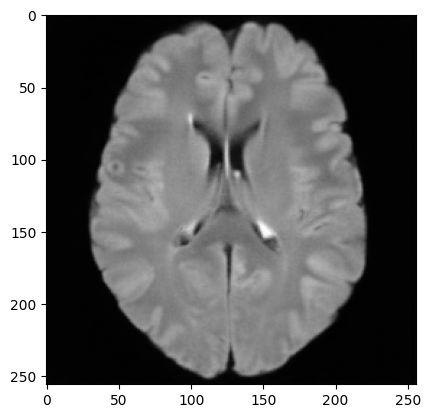

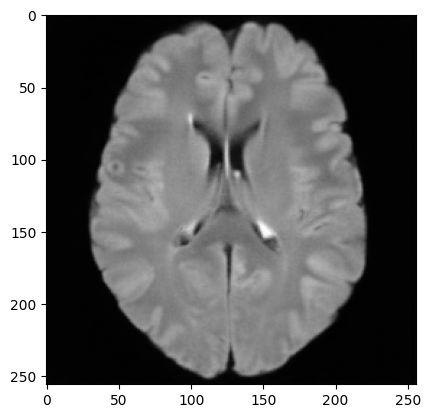

In [5]:
# take the first batch and reconstruct the image
batch = next(iter(train_dataloader))
batch = batch.to(device)
print(batch.shape)
reconstruction_v1 = vae.decode(batch / vae.config.scaling_factor).sample
reconstruction = vae.decode(batch / vae.config.scaling_factor, return_dict=False)[0]
print(reconstruction.shape)

# plot the reconstructionstructed image
import matplotlib.pyplot as plt
plt.imshow(reconstruction[0,0].detach().cpu().numpy(), cmap='gray')
plt.show()
plt.imshow(reconstruction_v1[0,0].detach().cpu().numpy(), cmap='gray')
plt.show()

In [7]:
import numpy as np
latent_files = [f for f in os.listdir(data_dir) if f.endswith(".npy")]

latents = []
for file in latent_files:
    latents.append(np.load(os.path.join(data_dir, file)))

latents = np.stack(latents)
print(f"Latent Mean: {latents.mean()}, Latent Std: {latents.std()}")


Latent Mean: -0.1489267647266388, Latent Std: 1.1394840478897095


In [8]:
vae.config.scaling_factor

0.18215